In [2]:
import sys
sys.path.append(r"C:/Users/TCSPC/Documents/GitHub/2pscopecontrol/notebooks")
import scopecontrolwidget as scw

Device API version 70, Module API version 10
Loaded devices: ('COM1', 'COM2', 'COM7', 'PIZStage', 'XYStage', 'SutterHub', 'Wheel-A', 'Shutter-A', 'Core')
DriverVersion(major_version=18, minor_version=5, update_version=0)
Device(name=Dev1)
Kinesis devices: [('27253344', 'Brushed Motor Controller'), ('27004338', 'Brushed Motor Controller')]
pyVISA resources: ('TCPIP0::140.247.108.15::inst0::INSTR', 'ASRL1::INSTR', 'ASRL2::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL6::INSTR', 'ASRL7::INSTR', 'ASRL9::INSTR', 'ASRL10::INSTR')


Box(children=(Box(children=(Label(value='HWP'), FloatText(value=0.0), FloatText(value=0.0)), layout=Layout(dis…

# initialize MM-controlled devices

In [4]:
mm_dir = r"C:\Program Files\Micro-Manager-2.0"
mmc = pymmcore.CMMCore()
print(pymmcore.CMMCore().getAPIVersionInfo())

mmc.setDeviceAdapterSearchPaths([mm_dir])
mmc.loadSystemConfiguration(os.path.join(mm_dir, "MMConfig_xyz_shutter_filter2.cfg"))

print(list(mmc.getLoadedDevices()))

Device API version 70, Module API version 10
['COM1', 'COM2', 'COM7', 'PIZStage', 'XYStage', 'SutterHub', 'Wheel-A', 'Shutter-A', 'Core']


# initialize NI DAQ

In [5]:
system = nidaqmx.system.System.local()
print(system.driver_version)
for device in system.devices:
    print(device)

DriverVersion(major_version=18, minor_version=5, update_version=0)
Device(name=Dev1)


# initialize HWP and SYNC

In [20]:
kinesis_devices = Thorlabs.list_kinesis_devices()
sync_stage, hwp_stage = kinesis_devices[0], kinesis_devices[1]
hwp_ID, sync_ID = kinesis_devices[1][0], kinesis_devices[0][0]
hwp_scale = "stage"
sync_scale = 1920
print(kinesis_devices)

[('27253344', 'Brushed Motor Controller'), ('27004338', 'Brushed Motor Controller')]


In [21]:
hwp_mutex = threading.Lock()
sync_mutex = threading.Lock()
shutter_mutex = threading.Lock()
filtwhl_mutex = threading.Lock()
xystage_mutex = threading.Lock()
zpiezo_mutex = threading.Lock()
laser_mutex = threading.Lock()

Exception in thread Thread-5 (update_status_bg_t1):
Traceback (most recent call last):
  File "C:\Users\TCSPC\anaconda3\envs\scopecontrol\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\TCSPC\anaconda3\envs\scopecontrol\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\TCSPC\AppData\Local\Temp\ipykernel_912\3808541567.py", line 51, in update_status_bg_t1
  File "C:\Users\TCSPC\AppData\Local\Temp\ipykernel_912\3346340265.py", line 43, in SYNC_get_pos
RuntimeError: release unlocked lock


In [22]:
def hwp_home():
    global hwp_mutex

    hwp_mutex.acquire()
    try:
        with Thorlabs.KinesisMotor(hwp_ID, scale=hwp_scale) as hwp_stage:
            hwp_stage.home()
            hwp_stage.wait_for_home()
            hwp_stage.move_to(0)
    finally:
        hwp_mutex.release()
        
def sync_home():
    global sync_mutex

    sync_mutex.acquire()
    try:
        with Thorlabs.KinesisMotor(sync_ID, scale=sync_scale) as sync_stage:
            sync_stage.home()
            sync_stage.wait_for_home()
            sync_stage.move_to(0)
    finally:
        sync_mutex.release()

hwp_home()
sync_home()

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1b5c7ba8ee0>


In [23]:
def HWP_set_pos(target):
    global hwp_mutex

    hwp_mutex.acquire()
    try:
        with Thorlabs.KinesisMotor(hwp_ID, scale=hwp_scale) as hwp_stage:
            hwp_stage.move_to(target)
            hwp_stage.wait_for_stop()
    finally:
        hwp_mutex.release()
        
def HWP_get_pos():
    global hwp_mutex

    hwp_mutex.acquire()
    try:
        with Thorlabs.KinesisMotor(hwp_ID, scale=hwp_scale) as hwp_stage:
            pos = hwp_stage.get_position()
    finally:
        hwp_mutex.release()
    
    return pos

def SYNC_set_pos(target):
    global hwp_mutex

    sync_mutex.acquire()
    try:
        with Thorlabs.KinesisMotor(sync_ID, scale=sync_scale) as sync_stage:
            sync_stage.move_to(target)
            sync_stage.wait_for_stop()
    finally:
        sync_mutex.release()
        
def SYNC_get_pos():
    global sync_mutex

    sync_mutex.acquire()
    try:
        with Thorlabs.KinesisMotor(sync_ID, scale=sync_scale) as sync_stage:
            pos = sync_stage.get_position()
    finally:
        sync_mutex.release()
    
    return pos

def HWP_value_change(change):
    if (change["new"] >= 0) and (change["new"] <= 359.99):        
        HWP_set_pos(change["new"])
        
def SYNC_value_change(change):
    if (change["new"] >= 0) and (change["new"] <= 359.99):        
        SYNC_set_pos(change["new"])
        
def shutter_value_change(change):
    if change["new"]:
        mmc.setShutterOpen(True)
    else:
        mmc.setShutterOpen(False)
        
def filtwhl_value_change(change):
    mmc.setStateLabel("Wheel-A", "Filter-" + str(change["owner"].index))
    
def filtwhl_get_pos():
    currpos = mmc.getStateLabel("Wheel-A")
    currindex = wheel_values.index(currpos)
    return currindex

def XYZ_get_pos():
    XYpos = mmc.getXYPosition()
    X, Y = tuple(XYpos)
    Z = mmc.getPosition()
    return X, Y, Z

def X_set_pos_abs(new_X):
    XYpos = mmc.getXYPosition()
    X, Y = tuple(XYpos)
    mmc.setXYPosition(new_X["new"],Y)
    
def Y_set_pos_abs(new_Y):
    XYpos = mmc.getXYPosition()
    X, Y = tuple(XYpos)
    mmc.setXYPosition(X,new_Y["new"])
    
def Z_set_pos_abs(new_Z):
    print("newZ = ", new_Z["new"])
    mmc.setPosition(new_Z["new"])
    # mmc.setPosition(62)
    
# def X_set_pos_rel(factor=1):
#     dX = factor * form_items[7].children[1].value
#     X, Y = tuple(mmc.getXYPosition())
#     mmc.setXYPosition(X+dX,Y)
    
# def Y_set_pos_rel(factor=1):
#     dY = factor * form_items[8].children[1].value
#     X, Y = tuple(mmc.getXYPosition())
#     mmc.setXYPosition(X,Y+dY)
    
# def Z_set_pos_rel(factor=1):
#     dZ = factor * form_items[9].children[1].value
#     X, Y = tuple(mmc.getXYPosition())
    
#     Z = mmc.getPosition()
#     mmc.setPosition(Z+dZ)
    
def X_set_pos_rel(dX):
    X, Y = tuple(mmc.getXYPosition())
    mmc.setXYPosition(X+dX,Y)
    
def Y_set_pos_rel(dY):
    X, Y = tuple(mmc.getXYPosition())
    mmc.setXYPosition(X,Y+dY)
    
def Z_set_pos_rel(dZ):
    Z = mmc.getPosition()
    mmc.setPosition(Z+dZ)

In [24]:
filter_list = ["Empty", "460/50 NADH", "560/40", "Empty", "582/64 FAD2", "535/30 GFP/YFP", "530/35 GFP/YFP", "650/100 Mitotracker", "Unknown", "Empty"]
wheel_values = mmc.getStateLabels("Wheel-A")

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

X, Y, Z = XYZ_get_pos()

form_items = [
    Box([Label(value="HWP"), FloatText(HWP_get_pos()), FloatText()], layout=form_item_layout),
    Box([Label(value="SYNC"), FloatText(SYNC_get_pos()), FloatText()], layout=form_item_layout),
    Box([Label(value="Shutter"), Checkbox(), Checkbox()], layout=form_item_layout),
    Box([Label(value='Emission filter'), Dropdown(options=filter_list), Dropdown(options=filter_list)], layout=form_item_layout),
    Box([Label(value="X"), FloatText(X), FloatText()], layout=form_item_layout),
    Box([Label(value="Y"), FloatText(Y), FloatText()], layout=form_item_layout),
    Box([Label(value="Z"), FloatText(Z), FloatText()], layout=form_item_layout),
    Box([Label(value="dX"), FloatText(60), Button(description="<"), Button(description=">")], layout=form_item_layout),
    Box([Label(value="dY"), FloatText(60), Button(description="v"), Button(description="^")], layout=form_item_layout),
    Box([Label(value="dZ"), FloatText(0.5), Button(description="v"), Button(description="^")], layout=form_item_layout),
    Box([Label(value="Laser WL TARGET"), FloatText(), FloatText()], layout=form_item_layout),
    Box([Label(value="Laser MTRPOS TARGET"), FloatText(), FloatText()], layout=form_item_layout),
]

form_items[0].children[1].observe(HWP_value_change, names="value")
form_items[1].children[1].observe(SYNC_value_change, names="value")
form_items[2].children[1].observe(shutter_value_change, names="value")
form_items[3].children[1].observe(filtwhl_value_change, names="value")
form_items[4].children[1].observe(X_set_pos_abs, names="value")
form_items[5].children[1].observe(Y_set_pos_abs, names="value")
form_items[6].children[1].observe(Z_set_pos_abs, names="value")
form_items[7].children[2].on_click(lambda f: X_set_pos_rel(-form_items[7].children[1].value))
form_items[7].children[3].on_click(lambda f: X_set_pos_rel(form_items[7].children[1].value))
form_items[8].children[2].on_click(lambda f: Y_set_pos_rel(-form_items[8].children[1].value))
form_items[8].children[3].on_click(lambda f: Y_set_pos_rel(form_items[8].children[1].value))
form_items[9].children[2].on_click(lambda f: Z_set_pos_rel(-form_items[9].children[1].value))
form_items[9].children[3].on_click(lambda f: Z_set_pos_rel(form_items[9].children[1].value))



def update_status_bg_t1(form_items):
    """
    Update system status in the background
    """

    while True:
        time.sleep(0.1)
        form_items[0].children[-1].value = HWP_get_pos()
        form_items[1].children[-1].value = SYNC_get_pos()
        
def update_status_bg_t2(form_items):
    """
    Update system status in the background
    """

    while True:
        time.sleep(0.1)
        # form_items[0].children[-1].value = HWP_get_pos()
        # form_items[1].children[-1].value = SYNC_get_pos()
        form_items[2].children[-1].value = mmc.getShutterOpen()
        form_items[3].children[-1].index = filtwhl_get_pos()
        X, Y, Z = XYZ_get_pos()
        form_items[4].children[-1].value = X
        form_items[5].children[-1].value = Y
        form_items[6].children[-1].value = Z

t1 = threading.Thread(target=update_status_bg_t1, args=(form_items,))
t2 = threading.Thread(target=update_status_bg_t2, args=(form_items,))

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='100%'
))

display(form)

t1.start()
t2.start()

Box(children=(Box(children=(Label(value='HWP'), FloatText(value=0.0), FloatText(value=0.0)), layout=Layout(dis…

# settings

change to data directory for current FOV/cell

In [9]:
%cd C:\Users\TCSPC\Documents\__Arunachalam\29 - FCS setup\fov1

C:\Users\TCSPC\Documents\__Arunachalam\29 - FCS setup\fov1


## settings for initial image

In [10]:
# 1 micron = 4.65 px
fov_dim_1xzoom = 440 # um
zoom = 8 # for the test image
npx = 256 # for the test image
pxsize = fov_dim_1xzoom / (zoom*npx)
pxsize # in um

0.21484375

## settings for FCS acquisition

In [14]:
move_delay_s, acquisition_length_s, buffer_length_s = 0.5, 2.0, 0.1

## load image and identify target points

(2, 256, 256, 256)


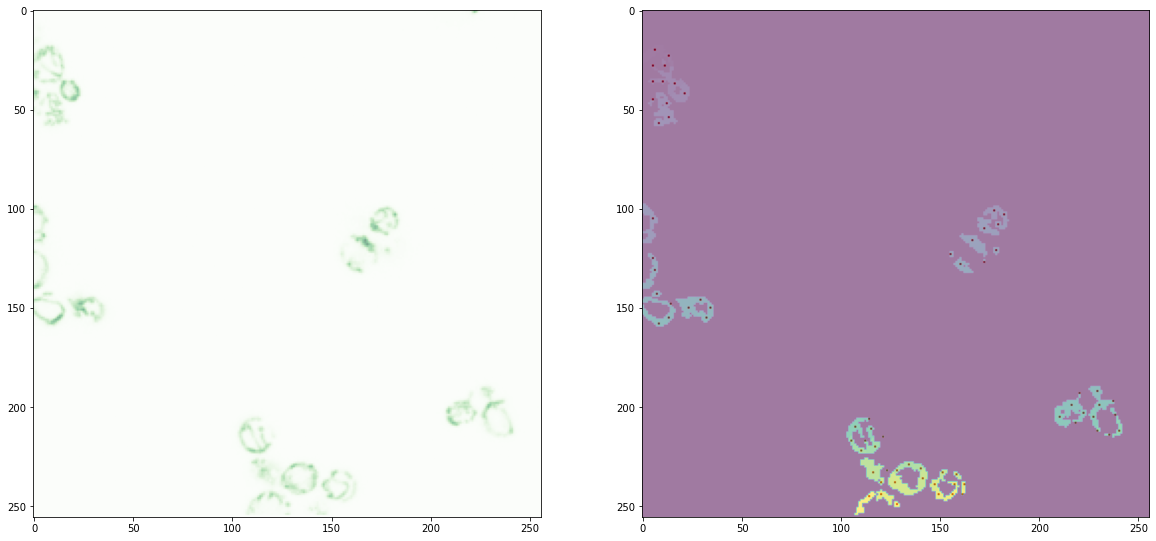

In [16]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

im = pc.SDT("SDT.sdt").intensity_image()[0]
ax[0].imshow(im, alpha=0.5, cmap="Greens")

im_binary = im > threshold_otsu(im)
distance = ndi.distance_transform_edt(im_binary)
coords = peak_local_max(distance, footprint=np.ones((5, 5)), min_distance=5)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=im_binary)
ax[1].imshow(labels)
ax[1].imshow(0.99*(markers > 0), cmap="Reds", alpha=0.5)

plt.show()

In [17]:
def calc_displacement(origin, destination=[127.5,127.5], px_to_micron=pxsize):
    dxy = destination - origin
    dX = -1*dxy[0]*px_to_micron
    dY = dxy[1]*px_to_micron
    return dX, dY

# curr_index, coords[curr_index], calc_displacement(coords[curr_index])

y, x = tuple(coords.T)
n = len(x)
xa = np.tile(x, (n,1))
dx2 = np.square(xa - xa.T)
ya = np.tile(y, (n,1))
dy2 = np.square(ya - ya.T)
dR = np.sqrt(dx2 + dy2)
ind_maxdist_0, ind_maxdist_1 = np.unravel_index(np.argmax(dR, axis=None), dR.shape)
dR[np.arange(n), np.arange(n)] = np.inf

with tqdm(total=len(x), desc="target points") as pbar:
    already_measured = np.zeros_like(x, dtype=bool)

    curr_index = ind_maxdist_0
    # print(curr_index)

    # acquire current point
    dX, dY = calc_displacement(coords[curr_index])
    X_set_pos_rel(dX)
    X_set_pos_rel(dY)
    time.sleep(move_delay_s)
    mmc.setShutterOpen(True)
    time.sleep(acquisition_length_s+buffer_length_s)
    mmc.setShutterOpen(False)
    dfdfdfd

    already_measured[curr_index] = True
    dR[:,curr_index] = np.inf
    pbar.update(1)


    while np.any(~already_measured):
        old_position = coords[curr_index]
        index_closest = np.argmin(dR[curr_index])
        curr_index = index_closest
        # print(curr_index)

        # acquire current point
        dX, dY = calc_displacement(old_position, destination=coords[curr_index])
        X_set_pos_rel(dX)
        X_set_pos_rel(dY)
        time.sleep(move_delay_s)
        mmc.setShutterOpen(True)
        time.sleep(acquisition_length_s+buffer_length_s)
        mmc.setShutterOpen(False)

        already_measured[curr_index] = True
        dR[:,curr_index] = np.inf
        pbar.update(1)

target points:   0%|          | 0/72 [00:00<?, ?it/s]

NameError: name 'dfdfdfd' is not defined